# Orders Analysis

First we'll focus on the orders side of the data to analyze what elements are associated with a particular review score.

To do this, we'll create a single data table with **all unique orders as index and all properties of these orders as columns.**

In [1]:
# Auto reload imported module everytime a jupyter cell is executed (handy for olist.order.py updates)
%load_ext autoreload
%autoreload 2

In [2]:
# Import usual modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Import olist data
from olist.data import Olist
olist=Olist()
data=olist.get_data()

## Inspect Features

Analyze features from Orders dataset by looking at distributions and correlations

In [87]:
# Get summary stats for each column
orders = Order().get_training_data()
orders.describe()

,wait_time,expected_wait_time,delay_vs_expected,dim_is_five_star,dim_is_one_star,review_score,number_of_products,number_of_sellers,price,freight_value
count,97007.000000,97007.000000,97007.000000,97007.000000,97007.000000,97007.000000,97007.000000,97007.000000,97007.000000,97007.000000
mean,12.564574,23.747123,0.774420,0.589061,0.100539,4.142237,1.142598,1.013968,136.895781,22.780658
std,9.542359,8.762100,4.747827,0.492007,0.300719,1.296559,0.540014,0.123772,208.701803,21.532648
min,0.533414,2.008009,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.850000,0.000000
25%,6.771296,18.337187,0.000000,0.000000,0.000000,4.000000,1.000000,1.000000,45.900000,13.850000
50%,10.225243,23.235741,0.000000,1.000000,0.000000,5.000000,1.000000,1.000000,86.000000,17.170000
75%,15.732506,28.416094,0.000000,1.000000,0.000000,5.000000,1.000000,1.000000,149.900000,24.020000
max,209.628611,155.135463,188.975081,1.000000,1.000000,5.000000,21.000000,5.000000,13440.000000,1794.960000


In [24]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97007 entries, 0 to 97014
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   order_id            97007 non-null  object 
 1   wait_time           97007 non-null  float64
 2   expected_wait_time  97007 non-null  float64
 3   delay_vs_expected   97007 non-null  float64
 4   order_status        97007 non-null  object 
 5   dim_is_five_star    97007 non-null  int64  
 6   dim_is_one_star     97007 non-null  int64  
 7   review_score        97007 non-null  int64  
 8   number_of_products  97007 non-null  int64  
 9   number_of_sellers   97007 non-null  int64  
 10  price               97007 non-null  float64
 11  freight_value       97007 non-null  float64
dtypes: float64(5), int64(5), object(2)
memory usage: 9.6+ MB


### Distributions for `wait_time`, `expected_wait_time`, and `delay_vs_expected`

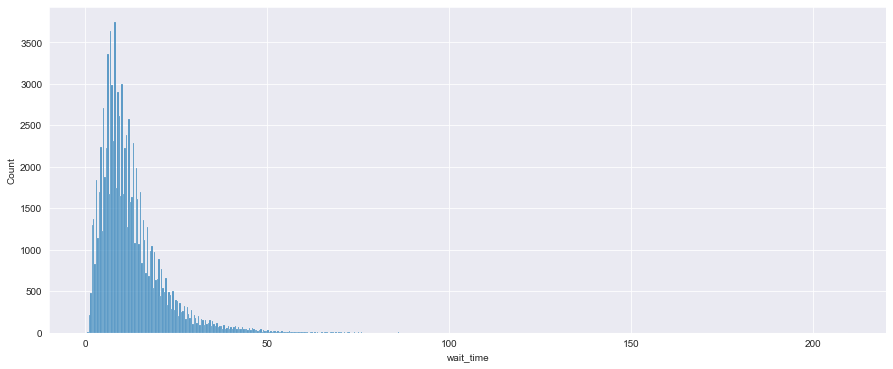

In [25]:
# 'wait_time' histogram
sns.set_style('darkgrid')
plt.figure(figsize=(15,6))
sns.histplot(orders.wait_time);

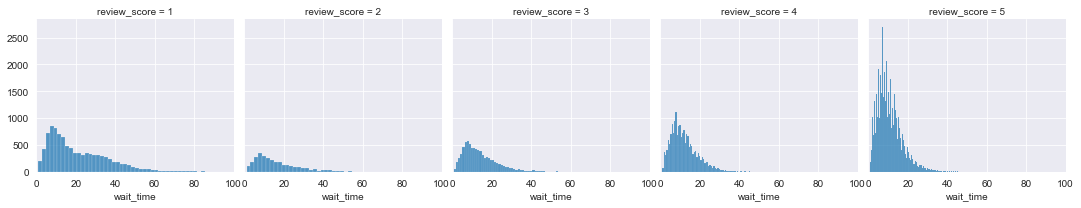

In [26]:
# Let's look at the distribution of 'wait_time' by review_score
g = sns.FacetGrid(data=orders, col='review_score')
g.map(sns.histplot, 'wait_time')
g.set(xlim=(0,100))
plt.show();

While the `wait_time` is generally similar across `review_score` categories, `review_score` has a larger proportion of orders with longer `wait_time`

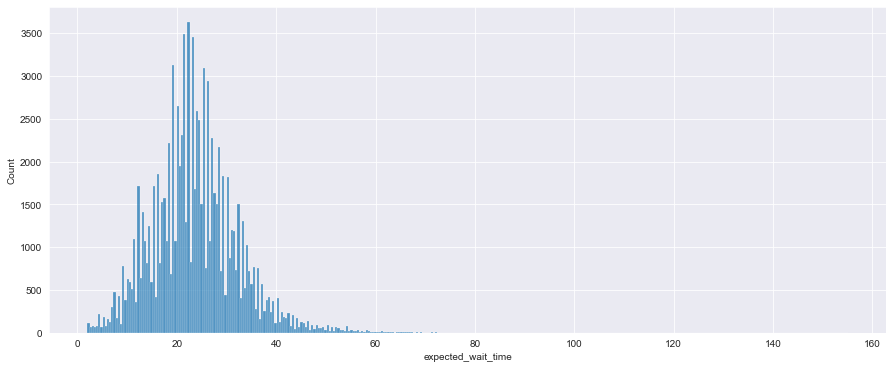

In [27]:
#'expected_wait_time' histogram
plt.figure(figsize=(15,6))
sns.histplot(orders.expected_wait_time);

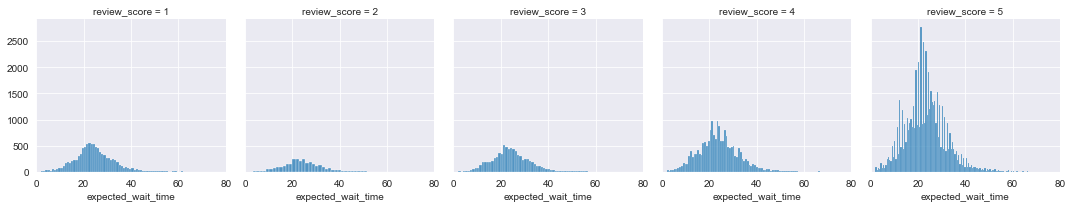

In [28]:
g1 = sns.FacetGrid(data=orders, col='review_score')
g1.set(xlim=(0,80))
g1.map(sns.histplot, 'expected_wait_time');

It appears that generally across review scores, there's a similar distribution of expected wait times

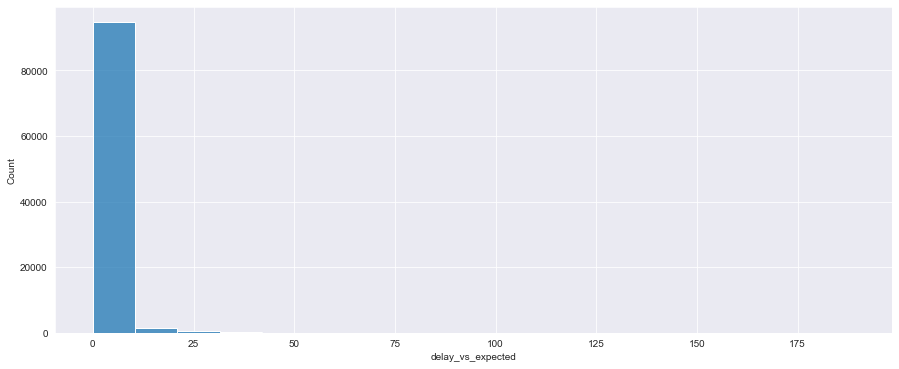

In [29]:
#'delay_vs_expected' histogram
plt.figure(figsize=(15,6))
sns.histplot(orders.delay_vs_expected);

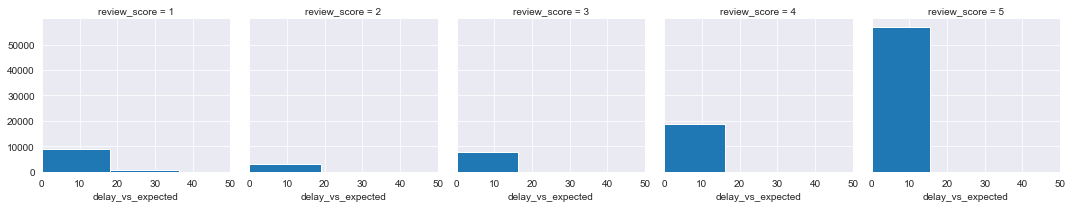

In [30]:
g2 = sns.FacetGrid(data=orders, col='review_score')
g2.set(xlim=(0,50))
g2.map(plt.hist, 'delay_vs_expected');

Looks like few orders actually end up taking longer to receive than what customers are expecting. But, for the few orders that get delayed, roughly half belong receive a review score of 1.

In [31]:
# Number of delayed orders
orders[orders.delay_vs_expected > 0].shape[0]

7865

In [32]:
# Number of delayed orders and receiving review score of 1
orders[(orders.delay_vs_expected > 0) & (orders.review_score == 1)].shape[0] 

3671

### Distributions for `dim_is_five_star`, `dim_is_one_star`, and `review_score`

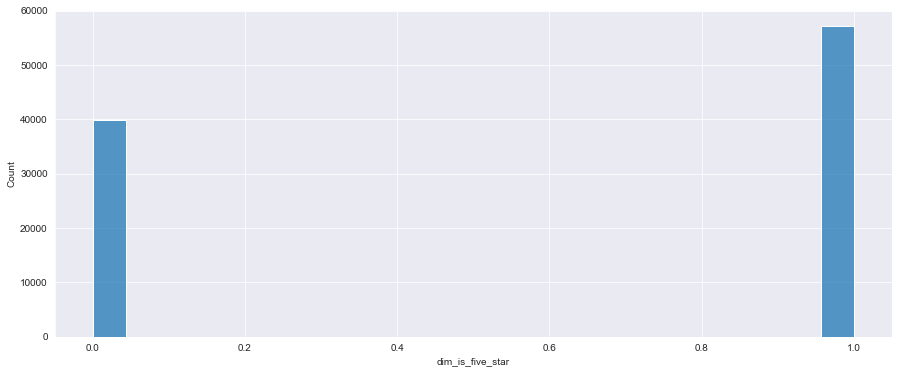

In [33]:
#'dim_is_five_star' histogram
plt.figure(figsize=(15,6))
sns.histplot(orders.dim_is_five_star);

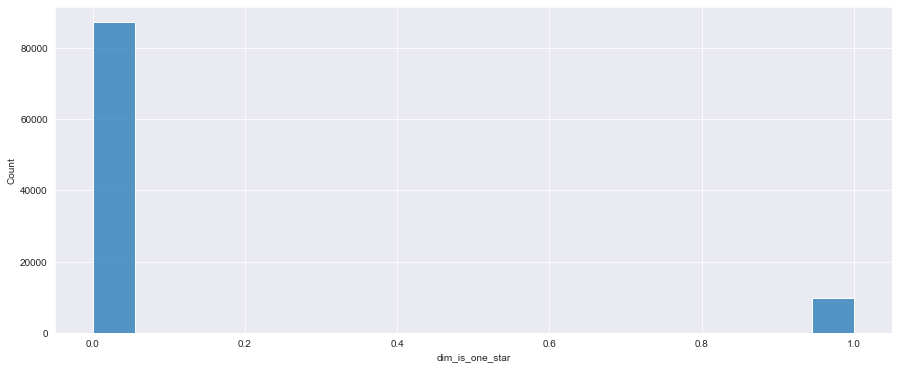

In [34]:
#'dim_is_one_star' histogram
plt.figure(figsize=(15,6))
sns.histplot(orders.dim_is_one_star);

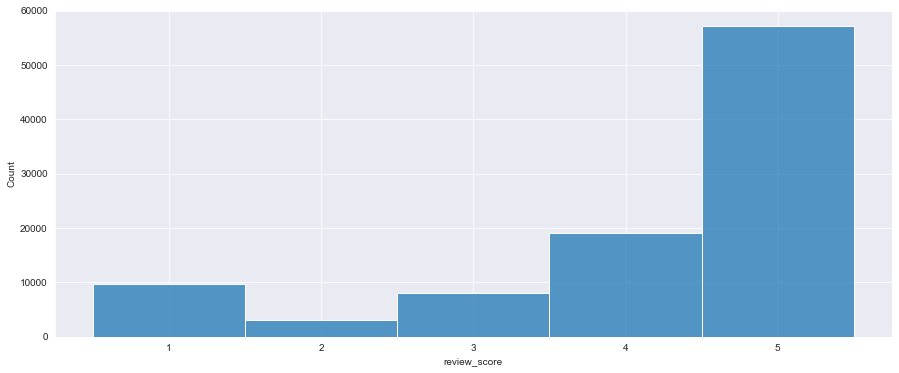

In [35]:
#'review_score' histogram
plt.figure(figsize=(15,6))
sns.histplot(orders.review_score, discrete=True);

### Distributions for `number_of_products`, `number_of_sellers`, `price`, and `freight_value`

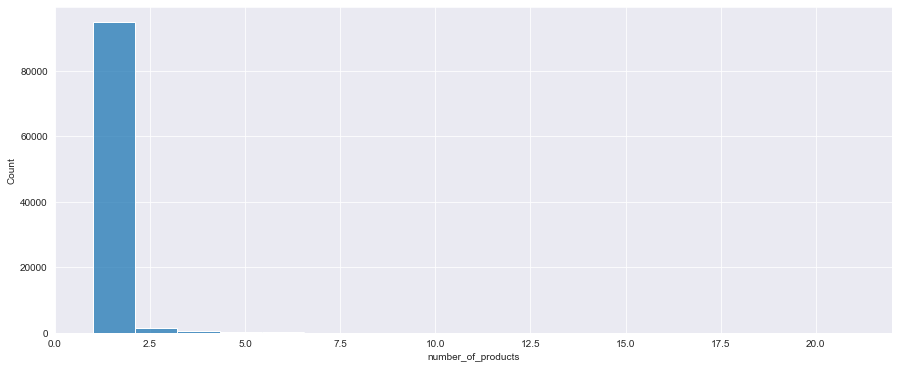

In [36]:
#'number_of_products' histogram
plt.figure(figsize=(15,6))
sns.histplot(orders.number_of_products);

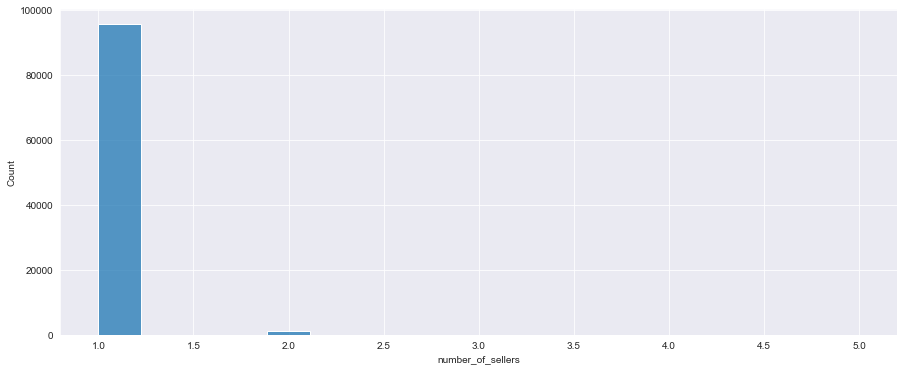

In [37]:
#'number_of_sellers' histogram
plt.figure(figsize=(15,6))
sns.histplot(orders.number_of_sellers);

Very few orders comprise more than one seller

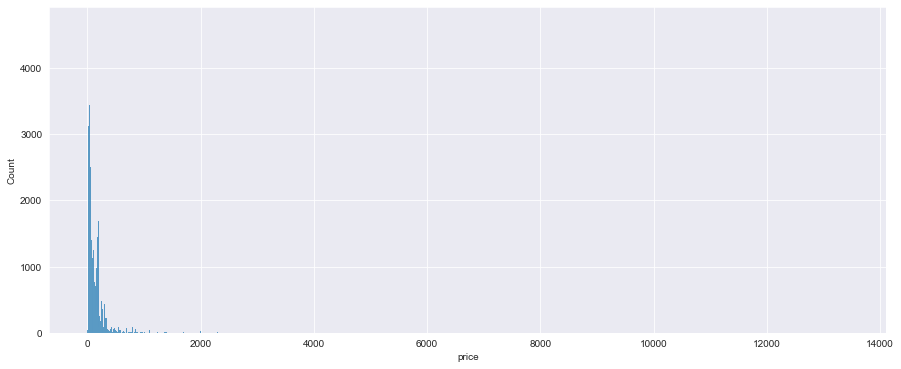

In [38]:
#'price' histogram
plt.figure(figsize=(15,6))
sns.histplot(orders.price);

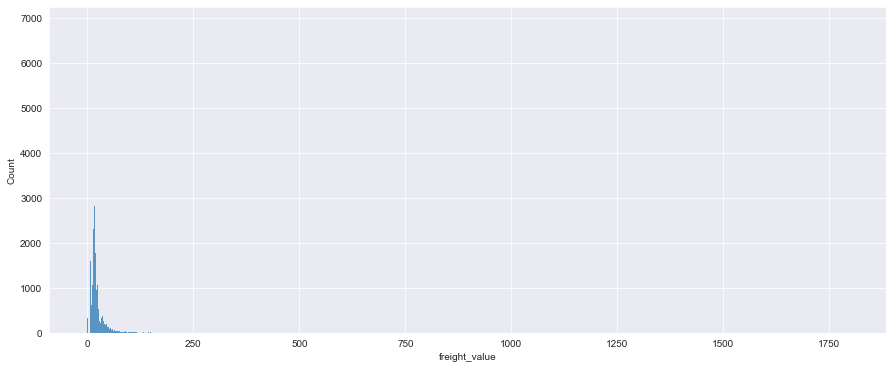

In [39]:
#'freight_value' histogram
plt.figure(figsize=(15,6))
sns.histplot(orders.freight_value);

## Correlations

Let's look to see if there are correlations between features in the Orders dataset

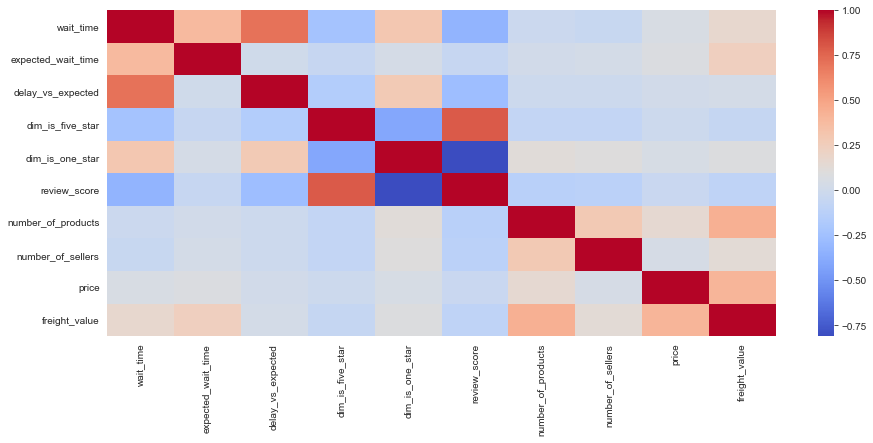

In [40]:
# Use heatmap to detect correlations with 'review_score'
plt.figure(figsize=(15,6))
sns.heatmap(orders.corr(), cmap='coolwarm');

The features `wait_time` and `delay_vs_expected` appear to have the strongest correlation with `review_score`.

In [41]:
# Let's look at the values of the correlation coefficients
orders.corr()['review_score']

wait_time            -0.334806
expected_wait_time   -0.052191
delay_vs_expected    -0.271885
dim_is_five_star      0.792079
dim_is_one_star      -0.810262
review_score          1.000000
number_of_products   -0.124405
number_of_sellers    -0.116317
price                -0.036006
freight_value        -0.091023
Name: review_score, dtype: float64

While the features `wait_time` and `delay_vs_expected` had higher correlations with our target variable `review_score` compared to the other features in our data, both features (`wait_time` and `delay_vs_expected`) are also highly correlated with each other (r=0.707), which makes sense since they both capture components of delivery duration for each customer's order. 

Since features that are highly correlated with each may be concealing a confounding variable and provide us with unreliable coefficients, we'll run some multivariate regression models that can provide a clearer sense of the impact from each feature on `review_score` while controlling for the others.

In [1]:
orders.corr()['wait_time']

NameError: name 'orders' is not defined

## Univariate Regression

Since the correlation coefficients for the features `wait_time` (r=33%) and `delay_vs_expected` (r=27%) have a stronger correlation with `review_score`, let's first look at them individually by running univariate regressions.


In [42]:
import statsmodels.formula.api as smf

### Simple regression of `review_score` against `wait_time`

In [43]:
formula = 'review_score ~ wait_time'
model1 = smf.ols(formula=formula, data=orders).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           review_score   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                 1.225e+04
Date:                Sun, 15 Aug 2021   Prob (F-statistic):               0.00
Time:                        19:13:22   Log-Likelihood:            -1.5707e+05
No. Observations:               97007   AIC:                         3.142e+05
Df Residuals:                   97005   BIC:                         3.142e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.7138      0.006    726.803      0.000       4.701       4.727
wait_time     -0.0455      0.000   -110.664      0.000      -0.046      -0.045
==============================================================================
Omnibus:                    19241.637   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            34157.401
Skew:                          -1.282   Prob(JB):                         0.00
Kurtosis:                       4.371   Cond. No.                         26.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Interpretation of Results**

For every additional day of `wait_time`, we can say with a 95% confidence level that the `review_score` is reduced by 4.6% on average (slope = -0.046). This suggests that there is an association between a longer `wait_time` and a lower `review_score`. 

- With a p-value close to zero, our coefficient for `wait_time` is statistically significant. 
- The R-squared indicates that 11% of the variance found in the `review_score` is attributable to `wait_time`.
- Since within the 95% confidence interval the slope does not contain the value zero, we can accept the coefficient as reliable

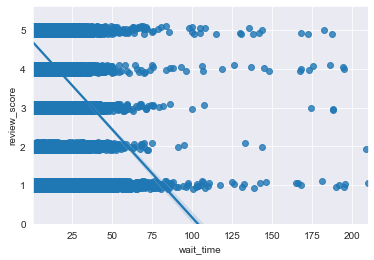

In [44]:
# Let's plot the univariate regression of 'review_score' on 'wait_time'
sns.regplot(x=orders.wait_time, y=orders.review_score, y_jitter=0.1)
plt.ylim(bottom=0);

### Simple regression of `review_score` against `delay_vs_expected`

In [45]:
formula = 'review_score ~ delay_vs_expected'
model2 = smf.ols(formula=formula, data=orders).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           review_score   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     7743.
Date:                Sun, 15 Aug 2021   Prob (F-statistic):               0.00
Time:                        19:13:28   Log-Likelihood:            -1.5912e+05
No. Observations:               97007   AIC:                         3.182e+05
Df Residuals:                   97005   BIC:                         3.183e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.1997      0.004   1034.674      0.000       4.192       4.208
delay_vs_expected    -0.0742      0.001    -87.995      0.000      -0.076      -0.073
==============================================================================
Omnibus:                    20264.119   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            46233.422
Skew:                          -1.191   Prob(JB):                         0.00
Kurtosis:                       5.401   Cond. No.                         4.88
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Interpretation of Results**

For each additional day of delay that the customer waits beyond the expected delivery date, we can say with a 95% confidence level that the `review_score` is reduced by 7.4% on average (slope = -0.074). This suggests that there is an association between delays in delivery and a lower `review_score`.   

- With a p-value close to zero, the coefficient for `delay_vs_expected` is statistically significant.
- The R-squared indicates that 7% of the variance found in the `review_score` is attributable to `delay_vs_expected`.
- Since within the 95% confidence interval the slope does not contain the value zero, we can accept the coefficient as reliable

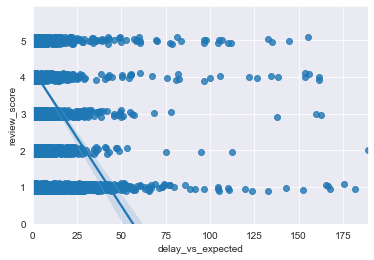

In [46]:
# Let's plot the univariate regression of 'review_score' on 'delay_vs_expected'
sns.regplot(x=orders.delay_vs_expected, y=orders.review_score, y_jitter=0.1)
plt.ylim(bottom=0);

## Multivariate Regression

While the features `wait_time` and `delay_vs_expected` had higher correlations with our target variable `review_score` compared to the other features in our data, both features (`wait_time` and `delay_vs_expected`) are also highly correlated with each other (r=0.707), which makes sense since they both capture components of delivery duration for each customer's order. 

Since features that are highly correlated with each may be concealing a confounding variable and provide us with unreliable coefficients, we'll run some multivariate regression models that can provide a clearer sense of the impact from each feature on `review_score` while controlling for the others.

In [47]:
orders.corr()['wait_time']

wait_time             1.000000
expected_wait_time    0.383318
delay_vs_expected     0.707487
dim_is_five_star     -0.234906
dim_is_one_star       0.306431
review_score         -0.334806
number_of_products   -0.019350
number_of_sellers    -0.040828
price                 0.055433
freight_value         0.166979
Name: wait_time, dtype: float64

### Multivariate Regression with 2 features: `wait_time` and `delay_vs_expected`
First, we'll regress `review_score` on just the two features `wait_time` and `delay_vs_expected`.

In [48]:
model3 = smf.ols('review_score ~ wait_time + delay_vs_expected', data=orders).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           review_score   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     6275.
Date:                Sun, 15 Aug 2021   Prob (F-statistic):               0.00
Time:                        19:13:33   Log-Likelihood:            -1.5694e+05
No. Observations:               97007   AIC:                         3.139e+05
Df Residuals:                   97004   BIC:                         3.139e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.6440      0.008    599.083      0.000       4.629       4.659
wait_time            -0.0388      0.001    -66.715      0.000      -0.040      -0.038
delay_vs_expected    -0.0191      0.001    -16.399      0.000      -0.021      -0.017
==============================================================================
Omnibus:                    19637.196   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            38268.583
Skew:                          -1.235   Prob(JB):                         0.00
Kurtosis:                       4.834   Cond. No.                         31.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Interpretation of Results**

While holding `delay_vs_expected` constant, each additional day of `wait_time` reduces the `review_score` by **3.8%** on average (slope = -0.0388). 

While holding `wait_time` constant, each additional day of `delay_vs_expected` reduces the `review_score` by **1.9%** on average (slope = -0.0191).

Therefore, in contrast to our univariate analysis, which suggested `delay_vs_expected` (**-7.4%**) has a stronger association with low `review_scores` than `wait_time` (**-4.6%**), we find the opposite to be the case in our multivariate analysis.

With a multivariate regression model that considered both features, the `wait_time` (**-3.9%**) has a stronger association with low `review_scores` than `delay_vs_expected` (**-1.9%**).

- Both features show ***p-values*** close to zero indicating that they are **statistically significant**
- Within the ***95% confidence interval***, slopes for the partial coefficients do not contain zero which allows us to consider them reliable
- ***R-squared*** is relatively low: only **11.5%** of the variations of `review_score` is explained by the variation of `wait_time` and `delay_vs_expected`

With these findings we can make the case that for the customer, the total wait time (from placing the order online to getting the package at the front door) has more impact on the review score than an order that arrives past the estimated delivery date. 

Therefore, for a CEO or manager hoping to improve order review scores, efforts to reduce the total wait time (perhaps in improving speed and efficiency in order processing or logistics handling) will do more than only trying to meet estimated delivery deadlines.


### Multivariate Regression with multiple features

Since the R-squared in our previous model with only two features was relatively low, in our next model we'll add other features from our data to build a more complete picture of what factors impact the order `review_score`. 

In [49]:
# Features to include in the model
features = [
    "wait_time",
    "delay_vs_expected",
    "number_of_products",
    "number_of_sellers",
    "price",
    "freight_value"]

Because these features are in different units, we'll standardize them first before putting them into our regression model. 

In [50]:
# standardize features by calculating respective z-scores:   Z = (X - mu) / sigma

orders_standardized = orders.copy()
for f in features:
    mu = orders[f].mean()
    sigma = orders[f].std()
    orders_standardized[f] = orders[f].map(lambda x: (x - mu) / sigma)

orders_standardized.head()

,order_id,wait_time,expected_wait_time,delay_vs_expected,order_status,dim_is_five_star,dim_is_one_star,review_score,number_of_products,number_of_sellers,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,-0.432597,15.544063,-0.16311,delivered,0,0,4,-0.264063,-0.112854,-0.512242,-0.652992
1,53cdb2fc8bc7dce0b6741e2150273451,0.127585,19.137766,-0.16311,delivered,0,0,4,-0.264063,-0.112854,-0.087186,-0.000959
2,47770eb9100c2d0c44946d9cf07ec65d,-0.332241,26.639711,-0.16311,delivered,1,0,5,-0.264063,-0.112854,0.110225,-0.165361
3,949d5b44dbf5de918fe9c16f97b45f8a,0.067507,26.188819,-0.16311,delivered,1,0,5,-0.264063,-0.112854,-0.440321,0.205239
4,ad21c59c0840e6cb83a9ceb5573f8159,-1.015545,12.112049,-0.16311,delivered,1,0,5,-0.264063,-0.112854,-0.560588,-0.652992


In [51]:
# model4; create formula for stats.model

formula = 'review_score ~ ' + ' + ' .join(features)
formula

'review_score ~ wait_time + delay_vs_expected + number_of_products + number_of_sellers + price + freight_value'

In [52]:
model4 = smf.ols(formula = formula, data = orders_standardized).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           review_score   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     2661.
Date:                Sun, 15 Aug 2021   Prob (F-statistic):               0.00
Time:                        19:13:34   Log-Likelihood:            -1.5545e+05
No. Observations:               97007   AIC:                         3.109e+05
Df Residuals:                   97000   BIC:                         3.110e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              4.1422      0.004   1073.800      0.000       4.135       4.150
wait_time             -0.3898      0.006    -69.175      0.000      -0.401      -0.379
delay_vs_expected     -0.0816      0.006    -14.772      0.000      -0.092      -0.071
number_of_products    -0.1465      0.004    -32.751      0.000      -0.155      -0.138
number_of_sellers     -0.1305      0.004    -32.377      0.000      -0.138      -0.123
price                 -0.0099      0.004     -2.339      0.019      -0.018      -0.002
freight_value          0.0350      0.005      7.301      0.000       0.026       0.044
==============================================================================
Omnibus:                    18510.939   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            36369.606
Skew:                          -1.162   Prob(JB):                         0.00
Kurtosis:                       4.897   Cond. No.                         2.63
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

To more easily compare the various partial coefficents of the features, we'll plot them on a bar chart.

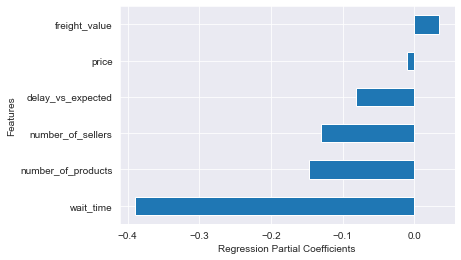

In [53]:
model4.params[1:].sort_values().plot(kind='barh')
plt.xlabel('Regression Partial Coefficients')
plt.ylabel('Features');

**Interpretation of Results**

With our new regression model including other features from our dataset, the `wait_time` variable (slope = -0.3898) has the most explanatory power for `review_score` relative to the other features. In this model, in comparison to `wait_time`, the difference in influence has widened with `delay_vs_expected` (slope = -0.0816)

Additionally, with this model, we can see that an increase in `number_of_sellers` and `number_of_products` per order, shows a decrease in `review_score`.

- The ***R-squared*** for this new model has not increased much and still only explains about 14.1% of the variance in the `review_score`. This points to most factors impacting the review score lying outside of the orders dataset.
- The ***p-values*** for our partial coefficients are mostly close to zero. However, the coefficient for `price` is small relative to its standard error, and its 95% confidence interval for is close to containing the value of zero, which would make the coefficient less reliable.   
- The overall model is **statistically significant** as its F-statistic is much greater than 1 (and a F-proba close to zero)

 ### Residuals

Besides evaluating the statistical signficance of our features and the R-squared of our model, we should also make sure the residuals are:
 - not correlated with one another (autocorrelation)
 - normally distributed 
 - constant variance (i.e. not exhibiting heteroscedasticity)
 

In [54]:
# Residuals = predicted values - real values
predicted_review_score = model4.predict(orders_standardized[features])
residuals = predicted_review_score - orders_standardized.review_score
residuals.head()

0    0.359790
1    0.160051
2   -0.668416
3   -0.805804
4   -0.412485
dtype: float64

**Check the Durbin-Watson test for autocorrelation**

With a scale of 0-4 (with 0 indicating positively autocorrelated, and 4 indicating negatively autocorrelated), our value of **2.009** allows to say that there is little autocorrelation among the residuals. Autocorrelation among residuals would imply that our confidence intervals are narrower and p-values lower than they ought to be, allowing us to be more confident than we should be with our findings.

**Check the Jarque-Bera test for normality & plot the distribution**

The Jarque-Bera statistic (normal=0) measures skewness and kurtosis to assess normality. A large value like **36369.606** indicates
that the distribution is not normal. With a p-value close to zero, this is statistically significant.


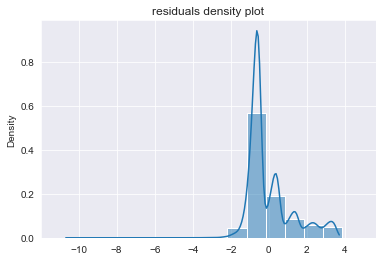

In [55]:
# Let's confirm this with a density plot of the residulas
sns.histplot(residuals, kde=True, stat='density', discrete=True)
plt.title('residuals density plot');

As we can see the numerous humps in the plot, this distribution does not look normal....

**Check the variance of the residuals for heteroskedasticity**

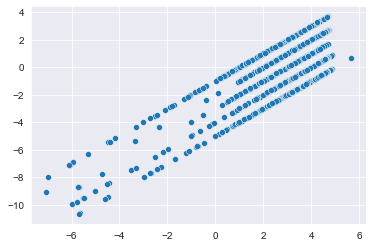

In [56]:
# Let's check the variance by plotting the residuals against the fitted values
sns.scatterplot(y=residuals, x=predicted_review_score);

In [57]:
from statsmodels.stats.diagnostic import het_breuschpagan as bp

bp_results = bp(residuals, exog_het=orders_standardized[features])
bp_results



(10735.405150798748, 0.0, 2011.757243414151, 0.0)

**Conclusion**

We can start to see that a linear regression model is failing along some basic assumptions (e.g. normality of residuals) and poor performance (e.g. R-squared is low). Since our review score (five-star rating system) is a categorical variable, we'll now look at applying a logistic regression model

# Logistic Regression

For our logistic regression models, we'll see how features have an impact on very poor 1-star reviews (`dim_is_one_star`) and on very good 5-star reviews (`dim_is_five_star`). 

Let's stick with the same features from our multivariate linear regression that had statistically significant partial coefficients.

In [79]:
features = ['wait_time', 'delay_vs_expected', 'number_of_products', 'number_of_sellers', 'price', 'freight_value']

To make sure we have a degree of collinearity among these features that isn't too high (vif < 10), let's look at the Variance Inflation Factor (vif). 

In [80]:
# Check for multi-colinearity by looking at Variance Inflation Factor (vif)
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
X = orders[features]
X

,wait_time,delay_vs_expected,number_of_products,number_of_sellers,price,freight_value
0,8.436574,0.0,1,1,29.99,8.72
1,13.782037,0.0,1,1,118.70,22.76
2,9.394213,0.0,1,1,159.90,19.22
3,13.208750,0.0,1,1,45.00,27.20
4,2.873877,0.0,1,1,19.90,8.72
...,...,...,...,...,...,...
97010,8.218009,0.0,1,1,72.00,13.08
97011,22.193727,0.0,1,1,174.90,20.10
97012,24.859421,0.0,1,1,205.99,65.02
97013,17.086424,0.0,2,1,359.98,81.18


In [81]:
df = pd.DataFrame()
df['vif_index'] = [vif(X.values, i) for i in range(X.shape[1])]
df['features'] = X.columns
df

,vif_index,features
0,5.482640,wait_time
1,2.057560,delay_vs_expected
2,7.363534,number_of_products
3,8.910229,number_of_sellers
4,1.721790,price
5,3.265091,freight_value


In [65]:
df = pd.DataFrame()
df['vif_index'] = [vif(X.values, i) for i in range(X.shape[1])]
df['features'] = X.columns
df

,vif_index,features
0,5.482640,wait_time
1,2.057560,delay_vs_expected
2,7.363534,number_of_products
3,8.910229,number_of_sellers
4,1.721790,price
5,3.265091,freight_value


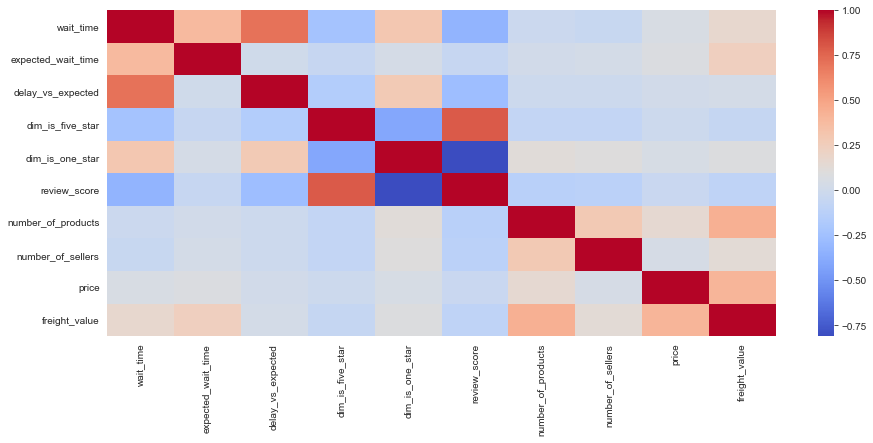

In [66]:
# Use heatmap to detect correlations with 'review_score'
plt.figure(figsize=(15,6))
sns.heatmap(orders.corr(), cmap='coolwarm');

In [67]:
# Let's look at the values of the correlation coefficients
orders.corr()['review_score']

wait_time            -0.334806
expected_wait_time   -0.052191
delay_vs_expected    -0.271885
dim_is_five_star      0.792079
dim_is_one_star      -0.810262
review_score          1.000000
number_of_products   -0.124405
number_of_sellers    -0.116317
price                -0.036006
freight_value        -0.091023
Name: review_score, dtype: float64

After noticing the high multi-collinearity between features, we can remove `number_of_sellers` and `price` to reduce the VIF for the remaining features.

In [82]:
# Fitting 2 LOGIT models (logit_one and logit_five) to predict dim_is_one_star and dim_is_five_star
logit_one = smf.logit(formula='dim_is_one_star ~' + ' + '.join(features), data=orders).fit()
print(logit_one.summary())

Optimization terminated successfully.
         Current function value: 0.280352
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:        dim_is_one_star   No. Observations:                97007
Model:                          Logit   Df Residuals:                    97000
Method:                           MLE   Df Model:                            6
Date:                Sun, 15 Aug 2021   Pseudo R-squ.:                  0.1407
Time:                        20:22:57   Log-Likelihood:                -27196.
converged:                       True   LL-Null:                       -31650.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -5.2641      0.069    -75.777      0.000      -5.400      -5.128
wait_

In [83]:
logit_five = smf.logit(formula='dim_is_five_star ~' + ' + '.join(features), data=orders).fit()
print(logit_five.summary())

Optimization terminated successfully.
         Current function value: 0.638115
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:       dim_is_five_star   No. Observations:                97007
Model:                          Logit   Df Residuals:                    97000
Method:                           MLE   Df Model:                            6
Date:                Sun, 15 Aug 2021   Pseudo R-squ.:                 0.05771
Time:                        20:23:01   Log-Likelihood:                -61902.
converged:                       True   LL-Null:                       -65693.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.4599      0.064     38.448      0.000       2.334       2.585
wait_

In [84]:
#Compare against Ordinary Least Squares (OLS) Regression 
linear_model = smf.ols(formula='review_score ~' + ' + '.join(features), data=orders).fit()
print(linear_model.summary())

                            OLS Regression Results                            
Dep. Variable:           review_score   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     2661.
Date:                Sun, 15 Aug 2021   Prob (F-statistic):               0.00
Time:                        20:23:06   Log-Likelihood:            -1.5545e+05
No. Observations:               97007   AIC:                         3.109e+05
Df Residuals:                   97000   BIC:                         3.110e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              6.0171      0

/Users/atat/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


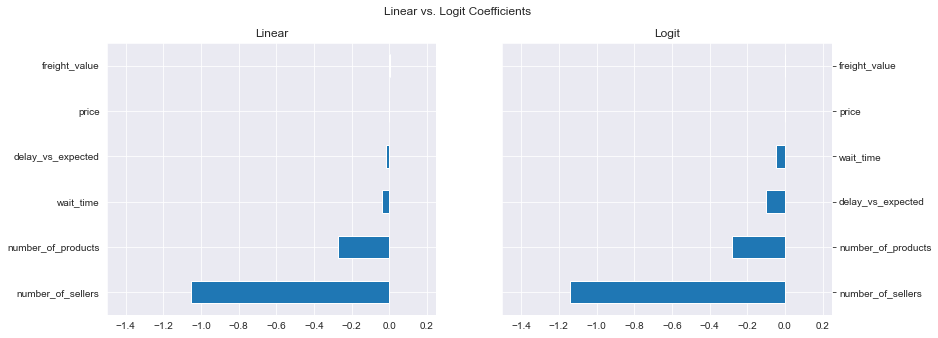

In [85]:
plt.figure(figsize=(13,5))
plt.suptitle('Linear vs. Logit Coefficients')
ax1 = plt.subplot(1,2,1)
ax1.set_title('Linear')
ax1.set_xlim(-1.5, 0.25)
linear_model.params[1:].sort_values().plot(kind='barh', ax=ax1)

ax2 = plt.subplot(1,2,2)
ax2.set_title('Logit')
ax2.yaxis.tick_right()
ax2.set_xlim(-1.5, 0.25)
logit_five.params[1:].sort_values().plot(kind='barh', ax=ax2)

plt.show()



In [ ]:
# According to the R-squared,roughly 14% of the variance can be explained from the selected features

In [ ]:
#Use ANOVA correlation test - 